## Importing required libraries

In [1]:
import sys 
sys.path.append('/home/aistudio/external-libraries')

import jax 
import jax.numpy as jnp
import optax
import jaxopt
from jax import device_put

jax.config.update("jax_enable_x64", True)

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_path = '/home/aistudio/Times_New_Roman.ttf'
prop = font_manager.FontProperties(fname=font_path)

## Data Loading and Generating

In [2]:
# Define the true time delay parameter for the model
real_lag = 0.5

# Define the true growth rate 'r' and carrying capacity 'k' for the system
real_r = 0.6
real_k = 100

# Define derived parameters 'a' and 'b' based on the biological interpretation:
# 'a' corresponds to the growth rate 'r'
# 'b' corresponds to the growth rate divided by the carrying capacity (r/k)
real_a = 0.6
real_b = 0.006

# Load the dataset with the given real lag value
data_path = f"/home/aistudio/work/NDDEs_for_DDE/Inverse_Problem/ex2/points_tau_{real_lag}.csv"
data = pd.read_csv(data_path)

# Extract given data points from the dataset and convert to JAX-compatible numpy array
init_data = jnp.array(data.iloc[:, [0, 1]].to_numpy())

# N_i represents the number of boundary conditions, conds represents the initial condition y(0) = 1
N_i = 1
t0 = jnp.ones([N_i, 1], dtype='float64') * 0.0
u0 = jnp.ones_like(t0)
conds = jnp.concatenate([t0, u0], axis=1)

# Initial key for random number generator
ik = 0

# Number of internal random points
N_f = 5000

# Range for sampling points
tmin, tmax = 0.0, 20.

# Generate random points within the specified range
jaxKey = jax.random.PRNGKey(ik)
inPoints = jax.random.uniform(jaxKey, minval=tmin, maxval=tmax, shape=(N_f,1), dtype='float64')

## Defining the Delay Differential Equation

Consider the delay differential equation with a single unknown time delay on the solution interval $[0,20]$:

\begin{equation}
\begin{cases}
\begin{aligned}
        y'(t) = {}& a \cdot y(t) - b \cdot y(t) \cdot y(t-\tau),,\qquad & t \geq 0\\
        y(t) = {}& 1, & t \leq 0
\end{aligned}
\end{cases}.
\end{equation}

In [3]:
# Define the differential equation
def DDE(t, u, lag, a, b):
    # Define u'(t)
    u_t = lambda t: jax.grad(lambda t: jnp.sum(u(t)))(t)

    # Define the right-hand side of the DDE
    rhs = a*u(t) - b*u(t)*jnp.where(t>lag, u(t-lag), 1)
    return u_t(t) - rhs

## DNNs Model Definition and Parameter Initialization

In [4]:
# Define the DNNs model
def DNNs(params, x):
    for w, b in params[:-2]:
        x = jnp.dot(x, w) + b
        x = jnp.tanh(x)
        
    w, b = params[-2]
    x = jnp.dot(x, w) + b
    return x

# Xavier initialization for the layer parameters
def random_layer_params_xavier(m, n, key):
    # Define lower and upper bounds for Xavier initialization
    lb, ub = -(1/jnp.sqrt(m)), (1/jnp.sqrt(n)) 

    w_key, b_key = jax.random.split(key)
    return lb + (ub-lb) * jax.random.uniform(w_key, (m, n)), jax.random.uniform(b_key, (n,))

# Initialize parameters for all layers in a fully-connected neural network with the specified sizes
def init_network_params(sizes, key):
    keys = jax.random.split(key, len(sizes))
    return [random_layer_params_xavier(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

## Defining the loss function

In [4]:
@jax.jit
def loss_fun(params, inPoints, conds, init_data):
    lag, a, b = params[-1][0], params[-1][1], params[-1][2]
    t_f = inPoints[:, [0]]
    ufunc = lambda t: DNNs(params, t)

    # Calculate the loss due to the differential equation
    loss_f = jnp.mean(DDE(t_f, ufunc, lag, a, b)**2)

    # Calculate the loss due to the initial conditions
    t_0, u_0 = conds[:, [0]], conds[:, [1]]
    loss_i = jnp.mean((ufunc(t_0) - u_0)**2)

    # Calculate the loss due to known data points
    t_i, u_i = init_data[:, [0]], init_data[:, [1]]
    loss_g = jnp.mean((u_i - ufunc(t_i))**2)

    # Compute the sum loss from all components
    loss_sum = loss_f + loss_i + loss_g

    # Calculate the weighted contribution of each loss component to the total loss
    w_f = loss_f / loss_sum
    w_i = loss_i / loss_sum
    w_g = loss_g / loss_sum

    # Compute the weighted average of the losses to form the total loss
    loss_total = w_f * loss_f + w_i * loss_i + w_g * loss_g

    return loss_total

## DNNs initialization

In [5]:
# Define the architecture of the neural network
netLayers = [1, 20, 40, 20, 1]

# Initialize network parameters using a predefined random key
key1 = jax.random.PRNGKey(ik)
params = init_network_params(netLayers, key1)

# Append the parameter for the inverse problem (time delay 'lag' and system parameters 'a' and 'b') to the network parameters
lag_and_system_params = jnp.array([0., 0., 0.], dtype=jnp.float64)
params.append(lag_and_system_params)

In [6]:
# Set the total number of training epochs
epochs = 160001

# Initialize lists to store parameter sets and loss values for each training iteration
params_history = []
loss_history = []

# Define the ADAM optimizer with an exponential decay learning rate scheduler
scheduler = optax.exponential_decay(init_value=1e-3, transition_steps=10000, decay_rate=0.9)
optimizer = optax.adam(learning_rate=scheduler)

# Initialize the optimizer state with the initial parameters
opt_state = optimizer.init(params)

# Decorate the update function with 'jax.jit' for just-in-time compilation to improve performance
@jax.jit
def update(params, opt_state, inPoints, conds, init_data):
    # Calculate the loss and gradients
    loss, grads = jax.value_and_grad(loss_fun)(params, inPoints, conds, init_data)
    # Update the parameters and optimizer state based on the calculated gradients
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# Execute the training loop over the specified number of epochs
for epoch in range(epochs):
    # Perform an update step and record the new parameters and loss
    params, opt_state, loss = update(params, opt_state, inPoints, conds, init_data)
    params_history.append(params[-1])  # Append the last parameter set
    loss_history.append(loss)          # Append the loss value
    # Periodically print the epoch number and the current loss
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

Epoch 0, Loss: 4722.1418927421955
Epoch 1000, Loss: 2183.9170316900154
Epoch 2000, Loss: 1363.890853596373
Epoch 3000, Loss: 681.2237387253128
Epoch 4000, Loss: 286.4690651035963
Epoch 5000, Loss: 91.71204464599099
Epoch 6000, Loss: 21.084640276670243
Epoch 7000, Loss: 3.4894568850165166
Epoch 8000, Loss: 0.27670704426927806
Epoch 9000, Loss: 0.05056892068286175
Epoch 10000, Loss: 0.1345542341749795
Epoch 11000, Loss: 0.01225270028103514
Epoch 12000, Loss: 0.009159682727657045
Epoch 13000, Loss: 4.971600995877151
Epoch 14000, Loss: 0.007026738267678775
Epoch 15000, Loss: 0.005862402534527391
Epoch 16000, Loss: 0.004972465155413103
Epoch 17000, Loss: 0.003974542002493498
Epoch 18000, Loss: 0.004610752195629198
Epoch 19000, Loss: 0.003483244271634843
Epoch 20000, Loss: 0.0028233251289580302
Epoch 21000, Loss: 0.002170094507150816
Epoch 22000, Loss: 0.0029945066592116376
Epoch 23000, Loss: 0.0022564157183655453
Epoch 24000, Loss: 0.001802056972617311
Epoch 25000, Loss: 1.4421080189685986


## Result visualization

In [7]:
# Convert each tuple in the params_history list to a standard Python list
# Each DeviceArray element is converted to float
params_data = [[float(x) for x in tup] for tup in params_history]

# Convert the loss_history DeviceArray elements to floats
loss_data = [float(x) for x in loss_history]

# Create DataFrames from the lists for parameters and loss data
df_params = pd.DataFrame(params_data, columns=['lag', 'a', 'b'])
df_loss = pd.DataFrame(loss_data, columns=['loss'])

# Concatenate the parameter and loss data into a single DataFrame
df_combined = pd.concat([df_params, df_loss], axis=1)

# Save the combined DataFrame to a CSV file, without the index column
# df_combined.to_csv('training_data.csv', index=False)

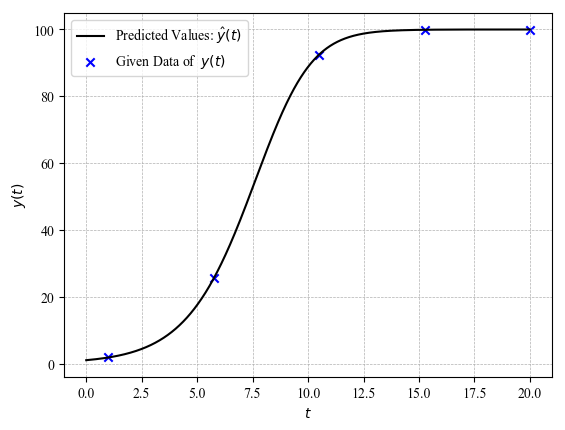

In [8]:
# Generate a set of time points linearly spaced between tmin and tmax
T = np.linspace(tmin, tmax, 10000).reshape(-1,1) 
# Evaluate the neural network at these time points to get predictions
nn_sol1 = DNNs(params, T)

# Extract time points and corresponding real data values from the dataset
t_points = data.iloc[:,0]
y_real = data.iloc[:,1]

# Set the figure size according to a 4:3 ratio, with width 16 cm and height 12 cm
plt.figure(figsize=(16 / 2.54, 12 / 2.54))

# Scatter plot for given data points
plt.scatter(t_points, y_real, label='Given Data of  $y(t)$', color='blue', marker='x')
# Line plot for the predicted values from the neural network
plt.plot(T, nn_sol1, 'k', label='Predicted Values: $\hat{y}(t)$')

# Add a legend with custom font properties
plt.legend(prop=prop)

# Set labels for the axes with custom font properties
plt.xlabel('$t$', fontproperties=prop)
plt.ylabel('$y(t)$', fontproperties=prop)

# Get the current axes to adjust tick labels and grid
ax = plt.gca()
# Set font properties for axis tick labels
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(prop)

# Enable grid lines on major ticks only, styled with dashes
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

# Save the plot as a high-resolution image
plt.savefig(f'DDE_IP_ex2_lag_{real_lag}_r_{real_r}_k_{real_k}.png', dpi=600, bbox_inches='tight')

# Display the plot
plt.show()

In [9]:
params[-1]

DeviceArray([0.50363444, 0.59892097, 0.00598908], dtype=float64)